
# 270. 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================

- 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, (무작위 초기화를 통해) 처음부터 합성곱 신경망(Convolutional Network) 전체를 작성하는 경우는 매우 적다.   


- 대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용

### 전이학습의 2 가지 시나리오:

-  **합성곱 신경망의 미세조정(finetuning)**: 신경망을 ImageNet 등으로 미리 학습한 신경망으로 초기화하고 parameter 미세 조정  


-  **고정된 특징 추출기로써의 합성곱 신경망**: 마지막 완전 연결층을 제외한 모든 신경망의 가중치를 고정. 마지막의 완전 연결층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습.  


### torch 제공 pre-trained models
```
    import torchvision.models as models  
    
    resnet18 = models.resnet18()  
    alexnet = models.alexnet()  
    vgg16 = models.vgg16()  
    squeezenet = models.squeezenet1_0()  
    densenet = models.densenet161()  
    inception = models.inception_v3()  
    googlenet = models.googlenet()  
    shufflenet = models.shufflenet_v2_x1_0()  
    mobilenet = models.mobilenet_v2()  
    resnext50_32x4d = models.resnext50_32x4d()  
    wide_resnet50_2 = models.wide_resnet50_2()  
    mnasnet = models.mnasnet1_0()  
```   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

데이터 불러오기
---------------

- **개미** 와 **벌** 을 분류하는 이진 분류 모델을 학습
    - 대략 120장 정도의 훈련 이미지와, 75장의 검증용 이미지를 이용
    - 전이학습을 통해 소량의 데이터로도 일반화 가능
    - ImageNet의 일부 data 이용

-  데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉토리에 압축을 푼다

In [2]:
!wget  https://download.pytorch.org/tutorial/hymenoptera_data.zip 
!unzip -q "hymenoptera_data.zip" 

--2022-02-03 08:03:23--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 65.9.78.70, 65.9.78.36, 65.9.78.40, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.9.78.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  60.3MB/s    in 0.7s    

2022-02-03 08:03:24 (60.3 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace hymenoptera_data/train/ants/1095476100_3906d8afde.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
# 데이터 증가(augmentation) 및 ResNet 에 적합한 normalization 적용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # ResNet
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ResNet
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# ImageFolder 라이브러리

- 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용할 수 있다. 각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들면 된다.

ImageFolder를 사용하기 위해선 가장 먼저 수집된 데이터의 폴더구조를 아래와 같이 설계해야한다  

최상위 경로 아래에 각각의 class name을 가지는 폴더를 구성하고 그 하위경로에 이미지가 저장되어있는 방식이다.
```
root_dir
    | --- ants/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- bees/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- rabbit/
    |      |--...
```

In [4]:
data_dir = 'hymenoptera_data'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'val')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['train', 'val']
['bees', 'ants']
['bees', 'ants']


### `datasets.ImageFolder(folder, transform)` data loader 생성

In [5]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'),  data_transforms['train']) 
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)

In [6]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [7]:
print(len(train_data), len(val_data))
print(class_names)

244 153
['ants', 'bees']


### 일부 이미지 시각화하기 

- torchvision.utils.make_grid(tensor)
    - tensor (Tensor or list) – (B x C x H x W)의 4D 미니 배치 텐서 또는 모두 같은 크기의 이미지 list 입니다.
    - nrow (int, optional) – 그리드의 각 행에 표시되는 이미지 수입니다. 최종 그리드 크기는 (B / nrow, nrow)입니다. 기본값은 8.

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = inp * std + mean
    inp  = np.clip(inp, 0, 1)
    plt.title(title)
    plt.imshow(inp)

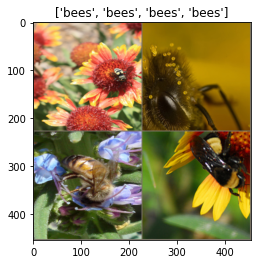

In [9]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs, nrow=2)
imshow(out, [class_names[x] for x in classes])

Model Train
--------------

-  학습율(learning rate) 관리(scheduling)
-  최적의 모델 구하기

- 아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러 객체(Object)

## 방법 1. pre-trained  ResNet 신경망 전체를 미세조정(finetuning)

- 미리 학습된 모델을 불러온 후 마지막의 완전 연결층 만을 새로 작성하고 **전체 parameter** 를 fine tuning

In [10]:
model_ft = torchvision.models.resnet18(pretrained=True)

num_features = model_ft.fc.in_features
num_features

512

In [11]:
# fc layer 출력의 크기를 1000 에서 2로 변경
model_ft.fc = nn.Linear(num_features, 2)
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

In [12]:
model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1 비율로 learning rate decay
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    s = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        model.train()  
        train_loss = 0
        train_acc  = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            z = model(x)
            _, preds = torch.max(z, 1)
        
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += torch.sum(preds == y).item()

        train_acc = train_acc / len(train_data)  
        train_loss = train_loss / len(train_data)
        
        scheduler.step()

        model.eval()  
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                z = model(x)
                _, preds = torch.max(z, 1)

                loss = criterion(z, y)

                val_loss += loss.item()
                val_acc += torch.sum(preds == y).item()

        val_acc  = val_acc / len(val_data)    
        val_loss = val_loss / len(val_data)

        print(f'eEpoch {epoch+1}/{num_epochs}==> train loss: {train_loss:.4f} ' + 
              f'val loss: {val_loss:.4f} ' + f'train acc: {train_acc:.2f} ' + 
              f'val acc: {val_acc:.2f}')

        # 모델을 깊은 복사(deep copy)함
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - s
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
eEpoch 1/25==> train loss: 0.1598 val loss: 0.0719 train acc: 0.67 val acc: 0.90
Epoch 1/24
----------
eEpoch 2/25==> train loss: 0.1246 val loss: 0.0613 train acc: 0.76 val acc: 0.92
Epoch 2/24
----------
eEpoch 3/25==> train loss: 0.1178 val loss: 0.0624 train acc: 0.80 val acc: 0.91
Epoch 3/24
----------
eEpoch 4/25==> train loss: 0.1688 val loss: 0.0899 train acc: 0.78 val acc: 0.90
Epoch 4/24
----------
eEpoch 5/25==> train loss: 0.2005 val loss: 0.0556 train acc: 0.77 val acc: 0.92
Epoch 5/24
----------
eEpoch 6/25==> train loss: 0.1665 val loss: 0.0996 train acc: 0.78 val acc: 0.90
Epoch 6/24
----------
eEpoch 7/25==> train loss: 0.1002 val loss: 0.1851 train acc: 0.84 val acc: 0.80
Epoch 7/24
----------
eEpoch 8/25==> train loss: 0.1010 val loss: 0.0683 train acc: 0.84 val acc: 0.90
Epoch 8/24
----------
eEpoch 9/25==> train loss: 0.0815 val loss: 0.0638 train acc: 0.86 val acc: 0.90
Epoch 9/24
----------
eEpoch 10/25==> train loss: 0.0732 val loss: 0.0715

In [15]:
predictions = []
labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        z = model_ft(x)
        _, preds = torch.max(z, 1)
        
        predictions.extend(preds.cpu().numpy())
        labels.extend(y.cpu().numpy())
        
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

print(f"accuracy = {len(correct_indices) / len(predictions) * 100:.2f} %")

accuracy = 92.16 %


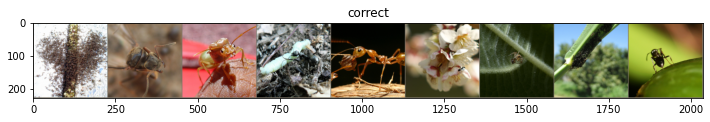

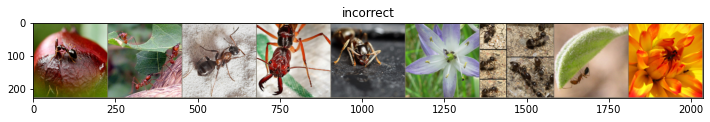

In [16]:
inputs = []
for i, idx in enumerate(correct_indices[:9]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=9)
plt.figure(figsize=(12, 4))
imshow(out, 'correct')

inputs = []
for i, idx in enumerate(incorrect_indices[:9]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=9)
plt.figure(figsize=(12, 4))
imshow(out, 'incorrect')

## 방법 2 : Pre-trained ResNet을 weight 고정된 특징 추출기로 사용

- 미리 학습된 모델을 불러온 후 마지막의 **완전 연결층 만을 새로 작성**하되 마지막 계층을 제외한 **신경망의 모든 부분을 고정** (``requires_grad == False`` 로 설정)하여 ``backward()`` 중에 gradient가 계산되지 않도록 함

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

In [18]:
# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_features = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_features, 2)

model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train & Evaluation

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
eEpoch 1/25==> train loss: 0.1418 val loss: 0.0835 train acc: 0.68 val acc: 0.87
Epoch 1/24
----------
eEpoch 2/25==> train loss: 0.1778 val loss: 0.0792 train acc: 0.69 val acc: 0.88
Epoch 2/24
----------
eEpoch 3/25==> train loss: 0.1630 val loss: 0.1223 train acc: 0.74 val acc: 0.82
Epoch 3/24
----------
eEpoch 4/25==> train loss: 0.0967 val loss: 0.0426 train acc: 0.83 val acc: 0.95
Epoch 4/24
----------
eEpoch 5/25==> train loss: 0.1367 val loss: 0.0676 train acc: 0.77 val acc: 0.89
Epoch 5/24
----------
eEpoch 6/25==> train loss: 0.0945 val loss: 0.0456 train acc: 0.85 val acc: 0.95
Epoch 6/24
----------
eEpoch 7/25==> train loss: 0.1640 val loss: 0.0479 train acc: 0.75 val acc: 0.95
Epoch 7/24
----------
eEpoch 8/25==> train loss: 0.0943 val loss: 0.0553 train acc: 0.86 val acc: 0.92
Epoch 8/24
----------
eEpoch 9/25==> train loss: 0.0941 val loss: 0.0492 train acc: 0.84 val acc: 0.93
Epoch 9/24
----------
eEpoch 10/25==> train loss: 0.0758 val loss: 0.0450

In [20]:
predictions = []
labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        z = model_conv(x)
        _, preds = torch.max(z, 1)
        
        predictions.extend(preds.cpu().numpy())
        labels.extend(y.cpu().numpy())
        
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

print(f"accuracy = {len(correct_indices) / len(predictions) * 100:.2f} %" )

accuracy = 95.42 %


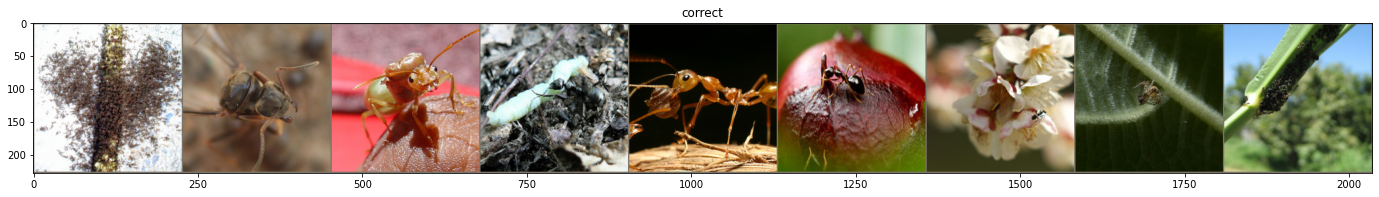

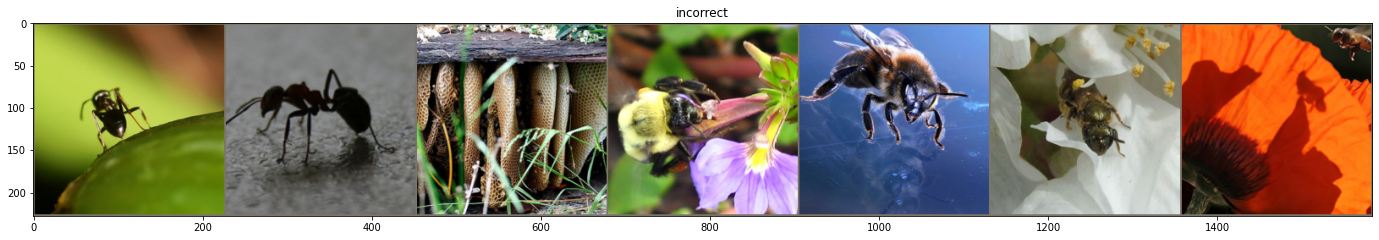

In [21]:
inputs = []
for i, idx in enumerate(correct_indices[:9]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=9)
plt.figure(figsize=(24, 8))
imshow(out, 'correct')

inputs = []
for i, idx in enumerate(incorrect_indices[:9]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=9)
plt.figure(figsize=(24, 8))
imshow(out, 'incorrect')